In [309]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tensorflow import Tensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import random
from deviceUtility import get_best_available_device

In [310]:
gpu = get_best_available_device()

________________________

Device manager:
Running on device: mps
________________________


### Constants

In [311]:
TIME_STEP_NUM = 700
EPOCH_NUM = 20
LEARNING_RATE = 1e-4
SUBSET_FRACTION = 0.01
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081
BETA_START = 0.0001
BETA_END = 0.005

### Scheduling

In [312]:
beta_schedule: Tensor = torch.linspace(BETA_START, BETA_END, TIME_STEP_NUM, device=gpu)
alpha_schedule: Tensor = torch.ones(beta_schedule.shape, device=gpu) - beta_schedule
alpha_bars: Tensor = torch.cumprod(alpha_schedule, dim=0)

In [313]:
def display_tensor_array(tensors: [(torch.Tensor, str)]):
    num_tensors = len(tensors)
    plt.figure(figsize=(3 * num_tensors, 3))
    for i, (tensor, title) in enumerate(tensors):
        plt.subplot(1, num_tensors, i + 1)
        plt.title(title, fontsize=10)
        tensor = tensor.cpu().detach().numpy()
        plt.imshow(tensor[0, 0], cmap='gray')
        plt.axis('off')
    plt.show()


def display_tensor(tensor: (torch.Tensor, str)):
    display_tensor_array([tensor])


def add_noise(initial_image: Tensor, t: int):
    """Returns a tuple of (noised_image, noise)"""
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1).to(gpu)
    noise_map = torch.randn_like(initial_image, device=gpu)
    noised_image = torch.sqrt(alpha_bar_t) * initial_image + torch.sqrt(1 - alpha_bar_t).to(
        gpu) * noise_map
    return noised_image, noise_map


### U-net

In [314]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(2, 2)

        # Contracting path
        self.encoder1 = self.double_conv_relu(1, 64)
        self.encoder2 = self.double_conv_relu(64, 128)

        # Bottleneck
        self.bottleneck = self.double_conv_relu(128, 256)

        # Expanding path
        self.up_convolution_3 = nn.ConvTranspose2d(256, 128, kernel_size=2,
                                                   stride=2)
        self.up_convolution_4 = nn.ConvTranspose2d(128, 64, kernel_size=2,
                                                   stride=2)

        self.decoder3 = self.double_conv_relu(256, 128)
        self.decoder4 = self.double_conv_relu(128, 64)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, image):
        # Contracting path
        enc1_out = self.encoder1(image)
        pool_enc1_out = self.max_pool(enc1_out)

        enc2_out = self.encoder2(pool_enc1_out)
        pool_enc2_out = self.max_pool(enc2_out)

        # Bottleneck
        bottle_out = self.bottleneck(pool_enc2_out)

        # Expanding path
        up_conv_3_out = self.up_convolution_3(bottle_out)
        crop_up_conv_3_out = crop_tensor(enc2_out, up_conv_3_out)
        dec3_out = self.decoder3(
            torch.cat([up_conv_3_out, crop_up_conv_3_out], dim=1))

        up_conv_4_out = self.up_convolution_4(dec3_out)
        crop_up_conv_4_out = crop_tensor(enc1_out, up_conv_4_out)
        dec4_out = self.decoder4(
            torch.cat([up_conv_4_out, crop_up_conv_4_out], dim=1))

        output = self.output_layer(dec4_out)

        return output

    @staticmethod
    def double_conv_relu(in_channels, out_channels):
        """Double convolution with ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def train_model(self, _optimizer, _data):
        self.train()
        data_len: int = len(_data)
        has_shown_dimensions = False

        for epoch in range(EPOCH_NUM):
            loss_epoch: int = 0

            for actual_image, _ in _data:
                actual_image: Tensor = actual_image.to(gpu)

                t: int = random.randint(0, TIME_STEP_NUM - 1)
                noised_image, actual_noise = add_noise(actual_image, t)

                predicted_noise: Tensor = self.forward(noised_image)

                if not has_shown_dimensions:
                    print(predicted_noise.shape)
                    print(actual_noise.shape)
                    print(noised_image.shape)
                    print(actual_image.shape)

                    has_shown_dimensions = True

                loss = self.loss(predicted_noise,
                                 actual_noise,
                                 noised_image,
                                 actual_image,
                                 random.randint(0, 10000) == 1
                                 )
                loss_epoch += loss

                loss.backward()

                optimizer.step()
                optimizer.zero_grad()
                
            loss_avg = loss_epoch / data_len
            print(f'Epoch [{epoch + 1}/{EPOCH_NUM}], Average loss: {loss_avg}')

    @staticmethod
    def loss(
        predicted_noise: Tensor,
        actual_noise: Tensor,
        noised_image: Tensor,
        actual_image: Tensor,
        showLoss=False):

        loss = (nn.MSELoss()(predicted_noise, actual_noise))

        if showLoss:
            tensors_with_titles = [
                (actual_image, "Actual Image"),
                (noised_image, "Noised Image"),
                (predicted_noise, "Predicted Noise"),
                (actual_noise, "Actual Noise")
            ]
            display_tensor_array(tensors_with_titles)
            print(f"the loss is {loss}")

        return loss


def crop_tensor(tensor: Tensor, target_tensor: Tensor):
    """Make the tensor the same size as the target tensor by cropping."""
    target_size = target_tensor.size()[2:]
    tensor_size = tensor.size()[2:]
    delta_h = (tensor_size[0] - target_size[0]) // 2
    delta_w = (tensor_size[1] - target_size[1]) // 2
    return tensor[:, :, delta_h:tensor_size[0] - delta_h,
           delta_w:tensor_size[1] - delta_w]


In [315]:
def load_training_data():
    """Load a subset of the MNIST training data"""
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(MNIST_MEAN, MNIST_STD)
         ]
    )
    mnist_full = MNIST(root='.', train=True, download=True, transform=transform)

    subset_size = int(len(mnist_full) * SUBSET_FRACTION)
    subset_indices = list(range(subset_size))

    mnist_subset = Subset(mnist_full, subset_indices)
    return DataLoader(mnist_subset, 1, shuffle=True)


# Train model
model = UNet().to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
dataloader = load_training_data()

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
Epoch [1/20], Average loss: 0.31393277645111084
Epoch [2/20], Average loss: 0.1708407700061798
Epoch [3/20], Average loss: 0.1516079157590866
Epoch [4/20], Average loss: 0.12621869146823883
Epoch [5/20], Average loss: 0.1314920336008072
Epoch [6/20], Average loss: 0.1283397227525711
Epoch [7/20], Average loss: 0.1237817257642746
Epoch [8/20], Average loss: 0.1173858493566513
Epoch [9/20], Average loss: 0.1120513528585434
Epoch [10/20], Average loss: 0.10477841645479202
Epoch [11/20], Average loss: 0.10005486011505127
Epoch [12/20], Average loss: 0.10475029796361923


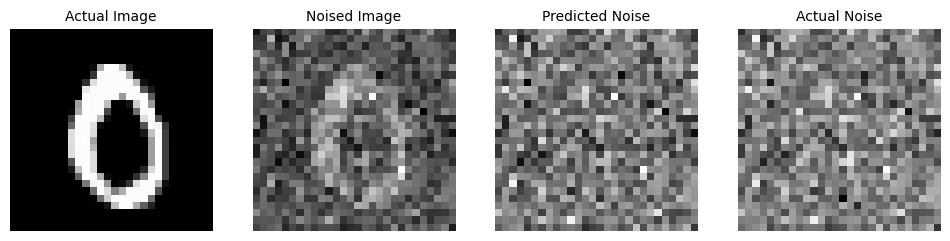

the loss is 0.05662603676319122
Epoch [13/20], Average loss: 0.10166498273611069
Epoch [14/20], Average loss: 0.10383547097444534
Epoch [15/20], Average loss: 0.10120466351509094
Epoch [16/20], Average loss: 0.0915796086192131
Epoch [17/20], Average loss: 0.09719329327344894
Epoch [18/20], Average loss: 0.09479682147502899
Epoch [19/20], Average loss: 0.08841873705387115
Epoch [20/20], Average loss: 0.09607438743114471


In [316]:
model.train_model(optimizer, dataloader)

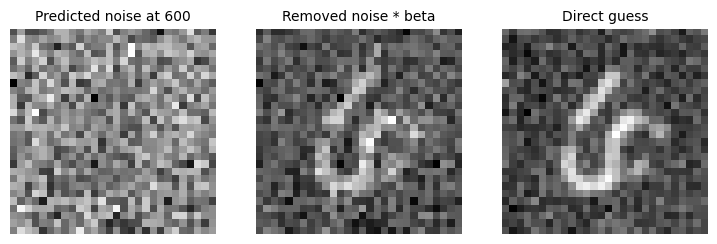

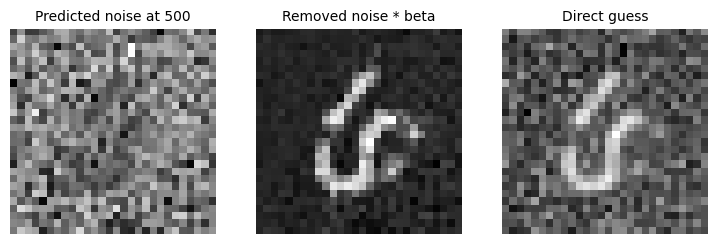

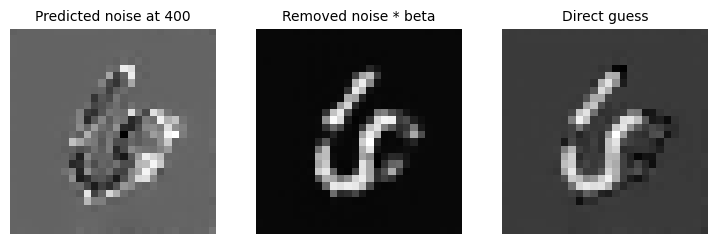

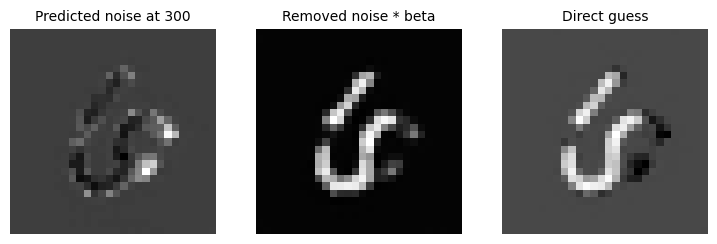

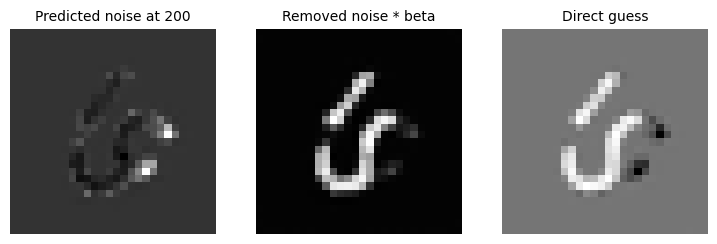

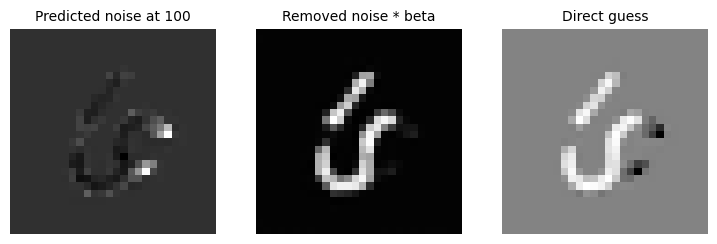

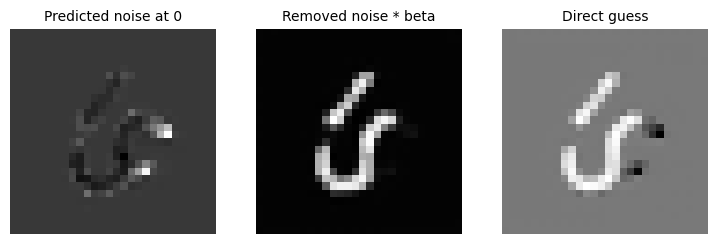

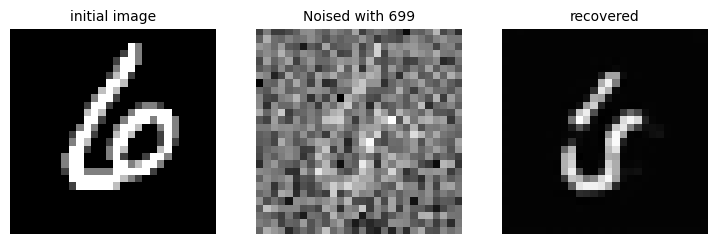

In [323]:
def reverse_diffusion(image, show_debug=True):
    model.eval()
    current = image
    with torch.no_grad():
        for t in reversed(range(TIME_STEP_NUM)):
            beta = beta_schedule[t]

            predicted_noise = model.forward(current)

            guess_directly = current - predicted_noise

            current = current - predicted_noise * beta

            if show_debug and t % 100 == 0:
                display_tensor_array([(predicted_noise, f"Predicted noise at {t}"),
                                      (current, "Removed noise * beta"),
                                      (guess_directly, "Direct guess")])

        return current


def show_next_image():
    first_image, _ = next(iter(dataloader))
    first_image = first_image.to(gpu)
    noised_image, _ = add_noise(first_image, TIME_STEP_NUM - 1)
    noised_image = noised_image.to(gpu)

    recovered_image: Tensor = reverse_diffusion(noised_image, True)
    display_tensor_array([
        (first_image, "initial image"),
        (noised_image, f"Noised with {TIME_STEP_NUM - 1}"),
        (recovered_image, "recovered")]
    )


show_next_image()
